# Lecture 10A — Notebook 10A.4: Log-Spectrum Choices, Numerical Stability, and Mini-Challenges

**Purpose:** Explore cepstrum variants (log magnitude vs log power), the role of epsilon, and practical ‘what to look for’ challenges.

This notebook follows the **EE519 hands-on protocol** (Lectures 7–8): manifest workflow, micro-checkpoints, debugging hints, saved figures, and reflection wrap-up.


In [1]:
import os, json, math, re
from pathlib import Path

import numpy as np
import scipy.signal as sig
import scipy.fft as fft
import matplotlib.pyplot as plt

# Optional: recording in notebook
try:
    import sounddevice as sd
    HAS_SD = True
except Exception as e:
    HAS_SD = False
    print("sounddevice not available (recording disabled).", e)

# Optional: playback in notebook
try:
    from IPython.display import Audio, display
    HAS_IPY_AUDIO = True
except Exception:
    HAS_IPY_AUDIO = False

# ---------- Project paths ----------
PROJECT_ROOT = Path.cwd() / "EE519_L10A_Project"
REC_DIR = PROJECT_ROOT / "recordings"
FIG_DIR = PROJECT_ROOT / "figures"
MANIFEST_PATH = PROJECT_ROOT / "manifest.json"

for d in [REC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def load_manifest(path=MANIFEST_PATH):
    if path.exists():
        return json.loads(path.read_text())
    return {"course":"EE519","lecture":"10A","created_utc":None,"clips":[]}

def save_manifest(manifest, path=MANIFEST_PATH):
    if manifest.get("created_utc") is None:
        manifest["created_utc"] = str(np.datetime64("now"))
    path.write_text(json.dumps(manifest, indent=2))
    print("Saved manifest:", path)

manifest = load_manifest()

def save_fig(fig, name, dpi=150):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved figure:", out)
    return out

# ---------- WAV I/O ----------
import wave
def write_wav(path: Path, x: np.ndarray, fs: int):
    x = np.asarray(x, dtype=np.float32)
    x = np.clip(x, -1.0, 1.0)
    x_i16 = (x * 32767.0).astype(np.int16)
    with wave.open(str(path), "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(fs)
        wf.writeframes(x_i16.tobytes())

def read_wav(path: Path):
    with wave.open(str(path), "rb") as wf:
        fs = wf.getframerate()
        n = wf.getnframes()
        x = np.frombuffer(wf.readframes(n), dtype=np.int16).astype(np.float32) / 32768.0
    return fs, x

def peak_normalize(x, target=0.98):
    m = np.max(np.abs(x)) + 1e-12
    return (x / m) * target

def play_audio(x, fs, label="audio"):
    if not HAS_IPY_AUDIO:
        print("(Audio playback not available)", label)
        return
    display(Audio(x, rate=fs))

def record_clip(seconds=2.0, fs=16000):
    if not HAS_SD:
        raise RuntimeError("sounddevice not available. Load wav files instead.")
    print(f"Recording {seconds:.1f}s @ {fs} Hz ...")
    x = sd.rec(int(seconds*fs), samplerate=fs, channels=1, dtype="float32")
    sd.wait()
    return fs, x.squeeze()

def add_clip_to_manifest(filename, label, fs, notes=""):
    clip = {
        "filename": filename,
        "label": label,
        "fs": int(fs),
        "notes": notes,
        "added_utc": str(np.datetime64("now")),
        "selections": {}
    }
    manifest["clips"].append(clip)
    save_manifest(manifest)
    return len(manifest["clips"]) - 1

def list_clips():
    for i,c in enumerate(manifest["clips"]):
        print(f"[{i}] {c['label']:12s}  {c['filename']}  fs={c['fs']}  notes={c.get('notes','')}")

# ---------- Framing helpers ----------
def frame_signal(x, N, H):
    if len(x) < N:
        x = np.pad(x, (0, N-len(x)))
    num = 1 + (len(x) - N)//H
    idx = np.arange(N)[None,:] + H*np.arange(num)[:,None]
    return x[idx]

def seconds_to_samples(t0, t1, fs, xlen):
    s0 = int(max(0, round(t0*fs)))
    s1 = int(min(xlen, round(t1*fs)))
    if s1 <= s0:
        raise ValueError("Bad selection: t1 must be > t0")
    return s0, s1

def samples_to_frame_range(s0, s1, N, H, xlen):
    f0 = max(0, int((s0 - N)//H) + 1)
    f1 = min(int((s1)//H), int((xlen-N)//H))
    if f1 < f0:
        f0 = max(0, int(s0//H))
        f1 = min(int((xlen-N)//H), f0)
    return f0, f1

def db(x):
    return 20*np.log10(np.maximum(x, 1e-12))

print("Project root:", PROJECT_ROOT)
print("Clips in manifest:", len(manifest["clips"]))


Project root: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project
Clips in manifest: 19


## 1) Choose a clip/frame (single-frame focus for clear comparisons)


In [2]:
list_clips()
CLIP_IDX = 0
clip = manifest["clips"][CLIP_IDX]
fs, x = read_wav(REC_DIR/clip["filename"])
x = peak_normalize(x)

# Default framing (can use manifest selection if available)
WIN_MS, HOP_MS = 25, 10
N = int(WIN_MS*1e-3*fs); H = int(HOP_MS*1e-3*fs)
window = sig.windows.hann(N, sym=False)

frames = frame_signal(x, N, H)
FRAME_IDX = min(10, len(frames)-1)
print("Using FRAME_IDX:", FRAME_IDX, "Total frames:", len(frames))


[0] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[1] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[2] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[3] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[4] sentence      student_sentence.wav  fs=16000  notes=short sentence
[5] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[6] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[7] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[8] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[9] vowel_i       student_vowel_i.wav  fs=16000  notes=steady /i/
[10] vowel_u       student_vowel_u.wav  fs=16000  notes=steady /u/
[11] fricative_s   student_fricative_s.wav  fs=16000  notes=steady /s/
[12] sentence      student_sentence.wav  fs=16000  notes=short sentence
[13] vowel_a       student_vowel_a.wav  fs=16000  notes=steady /a/
[14] vowel_a       student_vowel_a.wav  fs=16000  note

## 2) Compare log spectrum definitions

We will compare:
- log magnitude: `log(|X|)`
- log power: `log(|X|^2)` (equivalent to 2*log(|X|) up to scale)

Key learning: cepstrum is sensitive to how you take logs and stabilize zeros.


In [3]:
NFFT = 2048 if fs <= 16000 else 4096
fr = frames[FRAME_IDX] * window
X = fft.rfft(fr, n=NFFT)
mag = np.abs(X)

eps_list = [1e-6, 1e-12, 1e-3]  # intentionally varied

freqs = np.linspace(0, fs/2, len(mag))


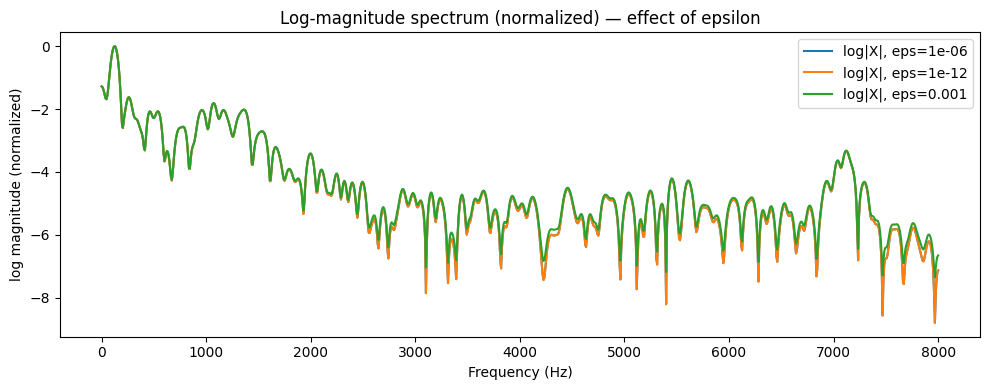

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\logmag_eps_effect_clip0_frame10.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/logmag_eps_effect_clip0_frame10.png')

In [4]:
fig = plt.figure(figsize=(10,4))
for eps in eps_list:
    logmag = np.log(mag + eps)
    plt.plot(freqs, logmag - np.max(logmag), label=f"log|X|, eps={eps}")
plt.title("Log-magnitude spectrum (normalized) — effect of epsilon")
plt.xlabel("Frequency (Hz)"); plt.ylabel("log magnitude (normalized)")
plt.legend()
plt.tight_layout(); plt.show()

save_fig(fig, f"logmag_eps_effect_clip{CLIP_IDX}_frame{FRAME_IDX}.png")


## 3) Cepstrum comparisons for different definitions


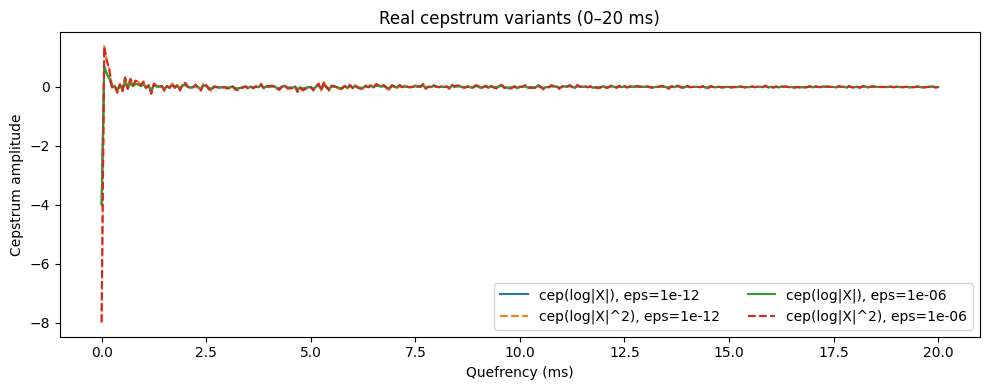

Saved figure: c:\Users\K\Documents\usc\ee519\ee519-lecture\lecture9\EE519_L10A_Project\figures\cep_variants_clip0_frame10.png


WindowsPath('c:/Users/K/Documents/usc/ee519/ee519-lecture/lecture9/EE519_L10A_Project/figures/cep_variants_clip0_frame10.png')

In [6]:
def real_cepstrum_from_mag(mag, eps, use_power=False):
    if use_power:
        logspec = np.log(mag**2 + eps)
    else:
        logspec = np.log(mag + eps)
    cep = fft.irfft(logspec, n=NFFT)
    return cep

quef_ms = (np.arange(NFFT)/fs)*1000.0
QMAX_MS = 20.0
qmask = quef_ms <= QMAX_MS

fig = plt.figure(figsize=(10,4))
for eps in [1e-12, 1e-6]:
    cep1 = real_cepstrum_from_mag(mag, eps, use_power=False)
    cep2 = real_cepstrum_from_mag(mag, eps, use_power=True)
    plt.plot(quef_ms[qmask], cep1[qmask], label=f"cep(log|X|), eps={eps}")
    plt.plot(quef_ms[qmask], cep2[qmask], linestyle="--", label=f"cep(log|X|^2), eps={eps}")
plt.title("Real cepstrum variants (0–20 ms)")
plt.xlabel("Quefrency (ms)"); plt.ylabel("Cepstrum amplitude")
plt.legend(ncol=2)
plt.tight_layout(); plt.show()

save_fig(fig, f"cep_variants_clip{CLIP_IDX}_frame{FRAME_IDX}.png")


## 4) Mini-challenges (in-class)

1) Pick a vowel frame and find a q-cut where the envelope is smooth but still shows formant structure.  
2) Pick a fricative frame and explain why pitch peaks disappear.  
3) Increase epsilon (e.g., 1e-3): what artifacts do you see in log spectrum and cepstrum?  
4) Try different windows (Hann vs Hamming) and comment on the cepstrum smoothness.


## Wrap-up
**What you learned:** practical cepstrum computation depends on log-spectrum definitions and numerical stability choices.  


## Reflection questions
1. Which epsilon gave the most stable cepstrum for your clip and why?  
2. Is log power cepstrum visually different from log magnitude cepstrum? Explain.  
3. What happens if the FFT has exact zeros (or near-zeros) and you do not stabilize?


### Answers

1. The largest episilon of 0.001 gave the most stability. It doesn't effect the logs or the FFT magnitudes while the other effect the logs. Going larger would effect the FFT magnitudes.
2. The comparison of episolon were similar but the structure were different. The power had more contrast since it scales more with magnitude.
3. The log will produce large values that show as sharp spikes or artifacts in the cepstrum.